In [403]:
%matplotlib inline
from vgg16 import *
np.set_printoptions(precision=4,linewidth=100)
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from itertools import chain
import bcolz

In [413]:
path="/home/zenith/Documents/CEBeg/CEProj"
batch_size=64
fname='gunProj.h5'
train='train'
valid='valid'

In [412]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224),class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
def plots_idx(idx, titles=None):
    plots([image.load_img(path +valid+'/' + filenames[i]) for i in idx], titles=titles)
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print(cm)
    thresh=cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment='center',color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [384]:
vgg = Vgg16()
batches = vgg.get_batches(path+train, batch_size=batch_size)
val_batches = vgg.get_batches(path+valid, batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

filenames = val_batches.filenames

Found 399 images belonging to 2 classes.
Found 70 images belonging to 2 classes.
Epoch 1/1
399/399 [==============================] - 171s - loss: 1.4024 - acc: 0.5990 - val_loss: 0.4013 - val_acc: 0.8571


In [385]:
trn_features = vgg.model.predict(trn_data, batch_size=batch_size)
val_features = vgg.model.predict(val_data, batch_size=batch_size)

In [386]:
val_batches.class_indices

{'nonviolence': 0, 'violence': 1}

[41 50 24 59]


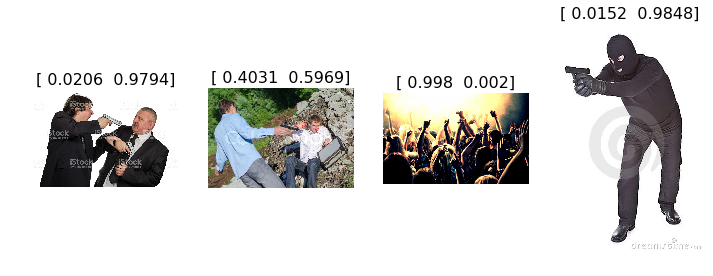

In [387]:
correct = np.where(np.round(val_features[:,1],decimals=0)==val_labels[:,1])[0]
idx = permutation(correct)[:4]
print(idx)
plots_idx(idx, val_features[idx])

[45 37 67 54]


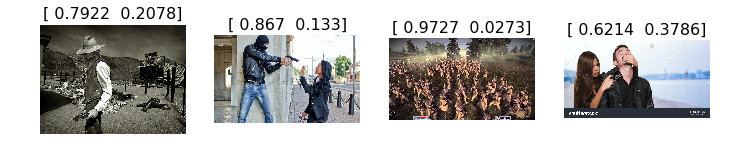

In [388]:
incorrect=np.where(np.round(val_features[:,1],decimals=0)!=val_labels[:,1])[0]
idx=permutation(incorrect)[:4]
print(idx)
plots_idx(idx,val_features[idx])

In [389]:
cm=confusion_matrix(val_labels[:,1],np.round(val_features[:,1],decimals=0))

[[35  2]
 [ 8 25]]


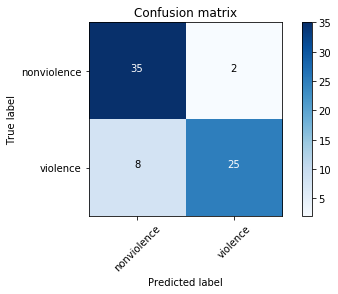

In [401]:
plot_confusion_matrix(cm, val_batches.class_indices)

In [402]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 3, 224, 224)   0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
zeropadding2d_92 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_8[0][0]                   
____________________________________________________________________________________________________
convolution2d_92 (Convolution2D) (None, 64, 224, 224)  1792        zeropadding2d_92[0][0]           
____________________________________________________________________________________________________
zeropadding2d_93 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_92[0][0]           
___________________________________________________________________________________________

In [404]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()
def load_array(fname):
    return bcolz.open(fname)[:]

In [407]:
save_array(path+'trn_data.dsv',trn_data)
save_array(path+'val_data.dsv',val_data)

In [ ]:
trn_data=load_array(path+'trn_data')
val_data=load_array(path+'trn_data')

In [408]:
vgg.model.save_weights(path+'gunProj.h5')

In [411]:
path=!pwd

In [414]:
def get_TVFolders(t=None,v=None):
    if t==None:
        train=input()
    else:
        train=t
    if len(os.listdir(path+train))!=2:
        print("The model is a binary decision classifier. Number of subfolders should be two")
        return None
    if v==None:
        valid=input()
    else:
        valid=v
    if len(os.listdir(path+valid))!=2:
        print("The model is a binary decision classifier. Number of subfolders should be two")
        return None
    return train,valid

In [416]:
train,valid=get_TVFolders('train','valid')

In [418]:
def get_Path(p=None):
    if p==None:
        path=input()
    else:
        path=p